In [1]:
%matplotlib inline
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [2]:
import gym
from gym import spaces
import gym_dynamic_set_packing
import time

## pytorch distributions experiments

In [60]:
state = torch.tensor(np.ones((2,16), dtype='float32'))

In [61]:
state

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [87]:
net = nn.Sequential(
    nn.Linear(16, 32),
    nn.ReLU(),
    nn.Linear(32,2)
)

ValueError: Either `probs` or `logits` must be specified, but not both.

In [76]:
dist = torch.distributions.Categorical(net(state))

In [86]:
dist.log_prob(dist.sample())

tensor([-0.1060, -0.1060], grad_fn=<SqueezeBackward1>)

## training loop code

In [40]:
class RandomMatchAgent:
    "A simple agent for the 0/1 problem that always matches."
    def __init__(self, match_prob):
        self.policy_dist = torch.distributions.Categorical(torch.tensor([match_prob, 1 - match_prob], dtype=torch.float32))
        self.action_space = spaces.Discrete(2)

    def act(self, observation, reward, done):
        action_sample = self.policy_dist.sample()
        return action_sample.item()
    
    def learn(self, history_dict):
        pass

In [148]:
def train_loop(env, agent, episode_count, max_steps, quiet=False):
    done = False
    ep_rewards = []
    for i in tqdm(range(episode_count)):
        reward = 0.0
        if not quiet:
            print('episode {}'.format(i))
        ob = env.reset()
        total_reward = 0.0
        history_dict = {
            'actions': [],
            'observations': [],
            'rewards': []
        }
        for i in range(max_steps):
            history_dict['observations'].append(ob)
            action = agent.act(ob, reward, done)
            history_dict['actions'].append(action)
            ob, reward, done, _ = env.step(action)
            history_dict['rewards'].append(reward)
            total_reward += reward
            if not quiet:
                print('action taken: {}, reward: {}, new state: {}'.format(action, reward, env.render()))
        agent.learn(history_dict)
        history_dict = None
        if not quiet:
            print('total episode reward: {}'.format(total_reward))
        ep_rewards.append(total_reward)
    return ep_rewards

In [89]:
np.expand_dims(env_example.reset(),0)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)

In [130]:
def discounted_episode_returns(rewards, gamma=0.99):
    """
    Given a sequence of rewards, returns the sequence
    of the discounted returns (G_t) at each time step,
    with discount rate gamma (default 0.999).
    """
    # thanks to yuhao for writing this code for another project
    length = len(rewards)
    discounts = [gamma**x for x in range(length)]
    result = [np.dot(discounts[:length-i], rewards[i:]) for i in range(length)]
    return np.array(result, dtype='float32')

In [131]:
def pg_target(policy_dist, rewards, action_trajectory):
    """
    The policy gradient target loss (without baseline). Note it has to be negative,
    because TF optimizers only want to minimize. Rewards should be cumulative and discounted.
    All inputs should already be TensorFlow objects, not lists or np arrays.
    """
    return -torch.mean(policy_dist.log_prob(action_trajectory)*rewards)

In [132]:
class MLPMatchAgent:
    def __init__(self, observation_shape, gamma=0.99):
        self.action_space = spaces.Discrete(2)
        
        self.policy_net = nn.Sequential(
            nn.Linear(observation_shape, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32,2)
        )
        self.optimizer = torch.optim.Adam(self.policy_net.parameters())
        self.gamma = gamma
        ## need to compile for non-eager mode?
    
    def policy(self, observation_batch):
        return torch.distributions.Categorical(logits=self.policy_net(observation_batch))
    
    def act(self, observation, reward, done):
        "Act on a single observation, return an action."
        observation_as_batch = torch.tensor(np.expand_dims(observation, 0), dtype=torch.float32, requires_grad=False)
        action_sample = self.policy(observation_as_batch).sample().detach().numpy()
        return action_sample[0]
    
    def learn(self, history_dict):
        "Perform the policy gradient update with its optimizer and policy."
        
        self.optimizer.zero_grad()
        
        obs_tensor = torch.tensor(history_dict['observations'], dtype=torch.float32, requires_grad=False)
        returns_tensor = torch.tensor(discounted_episode_returns(history_dict['rewards'], gamma=self.gamma), dtype=torch.float32, requires_grad=False)
        actions_tensor = torch.tensor(history_dict['actions'], dtype=torch.float32, requires_grad=False)
        policy_dists = self.policy(obs_tensor)
        loss = pg_target(policy_dists,
                             returns_tensor,
                             actions_tensor)
        loss.backward()
        self.optimizer.step()

In [147]:
ag = MLPMatchAgent(16)
ag.act(env_example.reset(), 1.0, False)

1

## mlp example (not sure if training totally correct)

In [149]:
env_example = gym.make('DynamicSetPacking-silly-v0')
ag = MLPMatchAgent(env_example.observation_space.shape[0], gamma=0.999)
ep_rewards = train_loop(env_example, ag, 10, 10, quiet=True)

## blood types example

In [154]:
env_example = gym.make('DynamicSetPacking-gurobitest-v0')
ag = MLPMatchAgent(env_example.observation_space.shape[0], gamma=0.999)
ep_rewards = train_loop(env_example, ag, 1000, 50, quiet=True)

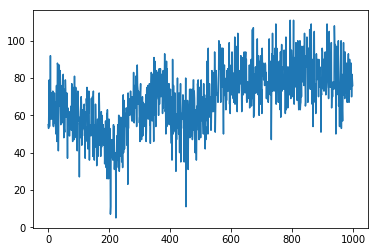

In [155]:
plt.plot(ep_rewards)

compare to random agent

In [8]:
class RandomMatchAgent:
    "A simple agent for the 0/1 problem that always matches."
    def __init__(self, match_prob):
        self.policy_dist = tfd.OneHotCategorical(probs=[1.0-match_prob, match_prob])
        self.action_space = spaces.Discrete(2)

    def act(self, observation, reward, done):
        action_sample = self.policy_dist.sample()
        return action_sample.numpy()
    
    def learn(self, history_dict):
        pass

In [9]:
env_example = gym.make('DynamicSetPacking-gurobitest-v0')
ag = RandomMatchAgent(0.5)
random_ep_rewards = train_loop(env_example, ag, 300, 50, quiet=True)

Instructions for updating:
Use tf.random.categorical instead.
Academic license - for non-commercial use only


KeyboardInterrupt: 

In [ ]:
plt.plot(random_ep_rewards)

## old loops

In [ ]:
def train_silly_env(agent, episode_count, max_steps):
    env = gym.make('DynamicSetPacking-silly-v0')
    reward = 0.0
    done = False
    for i in range(episode_count):
        print('episode {}'.format(i))
        ob = env.reset()
        total_reward = 0.0
        history_dict = {
            'actions': [],
            'observations': [],
            'rewards': []
        }
        for i in range(max_steps):
            history_dict['observations'].append(ob)
            
            action_onehot = agent.act(ob, reward, done)
            history_dict['actions'].append(action_onehot) # save the onehot version for logprob later
            action = np.argmax(action_onehot)
            ob, reward, done, _ = env.step(action)
            history_dict['rewards'].append(reward)
            total_reward += reward
            print('action taken: {}, reward: {}, new state: {}'.format(action, reward, env.render()))
        agent.learn(history_dict)
        print('total episode reward: {}'.format(total_reward))
def test_silly_env(agent, episode_count, max_steps):
    env = gym.make('DynamicSetPacking-silly-v0')
    reward = 0.0
    done = False
    for i in range(episode_count):
        print('episode {}'.format(i))
        ob = env.reset()
        total_reward = 0.0
        history_dict = {
            'actions': [],
            'observations': [],
            'rewards': []
        }
        for i in range(max_steps):
            history_dict['observations'].append(ob)
            
            action_onehot = agent.act(ob, reward, done)
            history_dict['actions'].append(action_onehot) # save the onehot version for logprob later
            action = np.argmax(action_onehot)
            ob, reward, done, _ = env.step(action)
            history_dict['rewards'].append(reward)
            total_reward += reward
            print('action taken: {}, reward: {}, new state: {}'.format(action, reward, env.render()))
        print('total episode reward: {}'.format(total_reward))

## old pg update func, saved

In [ ]:
def pg_update(history_dict, policy_model, optim):
    """Attempt at making a policy gradient update. Seems to be working.
    
    policy_model should output a TFP dist so we can get the log_prob.
    optim is any TensorFlow optimizer (Adam tends to work)
    history_dict should contain 'observations', 'rewards', and 'actions' from a rollout.
    """
    # policy_model outputs a TFP distribution
    # here, starting to define policy gradient operations. use gradient tape
    with tf.GradientTape() as tape:
        policy_dists = policy_model(tf.constant(history_dict['observations']))
        loss = pg_target(policy_dists, tf.constant(history_dict['rewards']), tf.constant(history_dict['actions']))
    gradients = tape.gradient(loss, policy_model.trainable_variables)
    optim.apply_gradients(zip(gradients, policy_model.trainable_variables))

## random agent example

In [ ]:
class RandomMatchAgent:
    "A simple agent for the 0/1 problem that always matches."
    def __init__(self, match_prob):
        self.policy_dist = tfd.OneHotCategorical(probs=[1.0-match_prob, match_prob])
        self.action_space = spaces.Discrete(2)

    def act(self, observation, reward, done):
        action_sample = self.policy_dist.sample()
        return action_sample.numpy()

In [ ]:
test_silly_env(RandomMatchAgent(0.3), 1, 10)